# Read data and randoms clsutering catalogs: 

**Aim:** Read data and randoms clustering catalogs with the expand and shuffling option for the randoms. 

**Important:** This code can be run with MPI without any modification (srun -n X python ... ).

In [1]:
%load_ext autoreload
%autoreload 2

## IMPORTANT: for now it works with cosmodesi environment and for internal uses only -> need to update this for public release.

In [2]:
import os
import sys
from pathlib import Path
import numpy as np

import logging
from mpytools import Catalog, setup_logging

sys.path.append('../')
from clustering_statistics.tools import read_clustering_catalog, get_catalog_fn, propose_fiducial

from mpi4py import MPI
mpicomm = MPI.COMM_WORLD

# disable jax warning:
logging.getLogger("jax._src.xla_bridge").setLevel(logging.ERROR)
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

setup_logging(level=(logging.INFO if mpicomm.rank == 0 else logging.ERROR))

Let's have a look to the GLAM Mocks ! 

In [3]:
# region = NGC, SGC, ALL (NGC+SGC), ... 
attrs = {'version': 'glam-uchuu-v1-altmtl', 'tracer': 'QSO', 'region': 'ALL', 'imock': 100}

# Different analysis are using different fiducial choices:
fiducial = propose_fiducial('catalog', tracer=attrs['tracer'], analysis='full_shape')
attrs.update(fiducial) 
print('Fiducial choice for catalog (Full Shape):',fiducial)
fiducial_png = propose_fiducial('catalog', tracer=attrs['tracer'], analysis='local_png')
print('Fiducial choice for catalog (Local PNG):',fiducial_png)

## For speed reason reduce the number of randoms for this demo:
attrs['nran'] = 1

print('')
print('data are located: ', get_catalog_fn(kind='data', **attrs))
print('randoms are located: ', get_catalog_fn(kind='randoms', **attrs))

Fiducial choice for catalog (Full Shape): {'weight': 'default-FKP', 'nran': 4, 'zranges': [(0.8, 2.1)], 'FKP_P0': 6000.0}
Fiducial choice for catalog (Local PNG): {'weight': 'default-oqe', 'nran': 4, 'zranges': [(0.8, 3.5)], 'FKP_P0': 30000.0}

data are located:  [PosixPath('/dvs_ro/cfs/cdirs/desi/mocks/cai/LSS/DA2/mocks/GLAM-Uchuu_v1/altmtl100/loa-v1/mock100/LSScats/QSO_NGC_clustering.dat.h5'), PosixPath('/dvs_ro/cfs/cdirs/desi/mocks/cai/LSS/DA2/mocks/GLAM-Uchuu_v1/altmtl100/loa-v1/mock100/LSScats/QSO_SGC_clustering.dat.h5')]
randoms are located:  [PosixPath('/dvs_ro/cfs/cdirs/desi/mocks/cai/LSS/DA2/mocks/GLAM-Uchuu_v1/altmtl100/loa-v1/mock100/LSScats/QSO_NGC_0_clustering.ran.h5'), PosixPath('/dvs_ro/cfs/cdirs/desi/mocks/cai/LSS/DA2/mocks/GLAM-Uchuu_v1/altmtl100/loa-v1/mock100/LSScats/QSO_SGC_0_clustering.ran.h5')]


In [4]:
help(get_catalog_fn)

Help on function get_catalog_fn in module clustering_statistics.tools:

get_catalog_fn(version=None, cat_dir=None, kind='data', tracer='LRG', region='NGC', weight='default-FKP', nran=10, imock=0, ext='h5', **kwargs)
    Return catalog filename(s) for given parameters.

    Parameters
    ----------
    version : str
        Catalog version. Options are 'data-dr1-v1.5', 'data-dr2-v2', 'holi-v1-complete', 'holi-v1-altmtl'.
    cat_dir : str, Path, optional
        Directory containing the catalogs. If None, pre-registered paths will be used based on version.
    kind : str
        Catalog kind. Options are 'data', 'randoms', 'full_data', 'full_randoms'.
    tracer : str
        Tracer name. Options are 'BGS', 'LRG', 'ELG', 'LRG+ELG', 'QSO'.
    region : str
        Region name. Options are 'NGC', 'SGC', 'N', 'S', 'ALL', 'NGCnoN', 'SGCnoDES'.
    weight : str
        Weight type. Options are 'default-FKP', 'defaut-bitwise-FKP', etc.
    nran : int
        Number of random catalogs.
    im

In [5]:
print('Reading data catalog...')
print(Catalog.read(get_catalog_fn(kind='data', **attrs), group='LSS', locking=False, mpicomm=mpicomm))
print('Reading randoms catalog...')
print(Catalog.read(get_catalog_fn(kind='randoms', **attrs), group='LSS', locking=False, mpicomm=mpicomm))

print('')
print('Randoms do not contain all the expected columns. This is for memory reason, we do not write and save RA,DEC,Z,... that are the same for all the mocks realisations.')
print('We are providing a way to read the catalogs with read_clustering_catalog function.')
print('')

Reading data catalog...
[000000.43] [0/1] 02-12 17:54  FileStack                 INFO     Reading /dvs_ro/cfs/cdirs/desi/mocks/cai/LSS/DA2/mocks/GLAM-Uchuu_v1/altmtl100/loa-v1/mock100/LSScats/QSO_NGC_clustering.dat.h5.
[000000.50] [0/1] 02-12 17:54  FileStack                 INFO     Reading /dvs_ro/cfs/cdirs/desi/mocks/cai/LSS/DA2/mocks/GLAM-Uchuu_v1/altmtl100/loa-v1/mock100/LSScats/QSO_SGC_clustering.dat.h5.
Catalog(csize=2022651, size=2022651, columns=['DEC', 'FRAC_TLOBS_TILES', 'NTILE', 'NX', 'PHOTSYS', 'RA', 'TARGETID', 'TILEID', 'WEIGHT', 'WEIGHT_COMP', 'WEIGHT_FKP', 'WEIGHT_IMLIN', 'WEIGHT_SYS', 'WEIGHT_ZFAIL', 'Z'])
Reading randoms catalog...
[000000.55] [0/1] 02-12 17:54  FileStack                 INFO     Reading /dvs_ro/cfs/cdirs/desi/mocks/cai/LSS/DA2/mocks/GLAM-Uchuu_v1/altmtl100/loa-v1/mock100/LSScats/QSO_NGC_0_clustering.ran.h5.
[000000.63] [0/1] 02-12 17:54  FileStack                 INFO     Reading /dvs_ro/cfs/cdirs/desi/mocks/cai/LSS/DA2/mocks/GLAM-Uchuu_v1/altmtl100

In [6]:
# Can pass other functions to get catalog fn in order to read others catalogs, default is: get_catalog_fn = get_catalog_fn
data = read_clustering_catalog(kind='data', mpicomm=mpicomm, get_catalog_fn=get_catalog_fn, **attrs) 
print(data)


print('')
print('To collect all the usefull columns for the randoms you need to provide a parent_randoms catalog in order to collect this information! This is achieve with expand;')
expand = {'parent_randoms_fn': get_catalog_fn(kind='parent_randoms', version='data-dr2-v2', tracer=attrs['tracer'], nran=attrs['nran'])}
randoms = read_clustering_catalog(kind='randoms', expand=expand, mpicomm=mpicomm, **attrs) 
print(randoms)

[000000.88] [0/1] 02-12 17:54  FileStack                 INFO     Reading /dvs_ro/cfs/cdirs/desi/mocks/cai/LSS/DA2/mocks/GLAM-Uchuu_v1/altmtl100/loa-v1/mock100/LSScats/QSO_NGC_clustering.dat.h5.
[000000.88] [0/1] 02-12 17:54  FileStack                 INFO     Reading /dvs_ro/cfs/cdirs/desi/mocks/cai/LSS/DA2/mocks/GLAM-Uchuu_v1/altmtl100/loa-v1/mock100/LSScats/QSO_SGC_clustering.dat.h5.
[000001.12] [0/1] 02-12 17:54  tools                     INFO     Multiplying individual weights by WEIGHT_FKP
Catalog(csize=2022651, size=2022651, columns=['RA', 'DEC', 'Z', 'NX', 'TARGETID', 'INDWEIGHT', 'POSITION'])

To collect all the usefull columns for the randoms you need to provide a parent_randoms catalog in order to collect this information! This is achieve with expand;
[000005.54] [0/1] 02-12 17:54  tools                     INFO     Expanding randoms
[000005.54] [0/1] 02-12 17:54  FileStack                 INFO     Reading /dvs_ro/cfs/cdirs/desi/survey/catalogs/DA2/LSS/loa-v1/LSScats/v2/dark

/global/u2/a/arosado/cai-dr2-clustering-products/nb/../clustering_statistics/tools.py:879: UserWarning: WEIGHT not in catalog
  warnings.warn('WEIGHT not in catalog')


[000025.31] [0/1] 02-12 17:54  tools                     INFO     Multiplying individual weights by WEIGHT_FKP
Catalog(csize=27929969, size=27929969, columns=['RA', 'DEC', 'Z', 'NX', 'TARGETID', 'INDWEIGHT', 'POSITION'])


In [7]:
# Let's have a look to the weight columns called INDWEIGHT (for individual weights):
data = read_clustering_catalog(kind='data', return_all_columns=True, mpicomm=mpicomm, **attrs)
print(attrs['weight'], data) 

# First compute the mean completeness weight as a function of 'NTILE'
from clustering_statistics.tools import  _compute_binned_weight
weight_ntl = _compute_binned_weight(data['NTILE'], data['WEIGHT_COMP'])[data['NTILE']] 
# Compute the total weights:
weight = data['WEIGHT_COMP'] * data['WEIGHT_SYS'] * data['WEIGHT_ZFAIL'] / weight_ntl

# For mocks, the result is not exactly the same because of the float compression in the mock files.
print('Without FKP weights:')
print(data['WEIGHT'])
print(weight)

print('With FKP weights:')
print(data['INDWEIGHT'])
print(weight * data['WEIGHT_FKP'])

[000034.92] [0/1] 02-12 17:54  FileStack                 INFO     Reading /dvs_ro/cfs/cdirs/desi/mocks/cai/LSS/DA2/mocks/GLAM-Uchuu_v1/altmtl100/loa-v1/mock100/LSScats/QSO_NGC_clustering.dat.h5.
[000034.93] [0/1] 02-12 17:54  FileStack                 INFO     Reading /dvs_ro/cfs/cdirs/desi/mocks/cai/LSS/DA2/mocks/GLAM-Uchuu_v1/altmtl100/loa-v1/mock100/LSScats/QSO_SGC_clustering.dat.h5.
[000035.03] [0/1] 02-12 17:54  tools                     INFO     Multiplying individual weights by WEIGHT_FKP
default-FKP Catalog(csize=2022651, size=2022651, columns=['RA', 'DEC', 'Z', 'WEIGHT', 'WEIGHT_COMP', 'WEIGHT_FKP', 'WEIGHT_SYS', 'WEIGHT_ZFAIL', 'FRAC_TLOBS_TILES', 'NTILE', 'NX', 'TARGETID', 'INDWEIGHT', 'POSITION'])
Without FKP weights:
[1.64160156 0.82080078 0.83007812 ... 0.97412109 0.97607422 0.96533203]
[1.64237141 0.82077736 0.83057769 ... 0.97456491 0.97643908 0.9651941 ]
With FKP weights:
[1.44474594 0.72123795 0.76245471 ... 0.81816587 0.83613109 0.81396232]
[1.44542348 0.72121737 0.7

In [9]:
# For the mocks, you can also reshuffle randoms on the fly (this is slow without MPI), especially to test RIC.

# First, pass expand if randoms do not have RA, DEC, and NTILE columns:
expand = {'parent_randoms_fn': get_catalog_fn(kind='parent_randoms', version='data-dr2-v2', tracer=attrs['tracer'], nran=attrs['nran'])}

# Then provide directory to merged data catalogs (we will draw the redshift from the concatenates mock data catalogs, removing the effect of RIC)
merged_dir = Path('/global/cfs/cdirs/desi/mocks/cai/LSS/DA2/mocks/desipipe/') /  attrs['version'] / 'merged'
reshuffle = {'merged_data_fn': get_catalog_fn(kind='data', cat_dir=merged_dir, **(attrs|dict(region='ALL')))}

randoms_reshuffled = read_clustering_catalog(kind='randoms', expand=expand, reshuffle=reshuffle, mpicomm=mpicomm, **attrs) 
print(randoms_reshuffled)

[000102.50] [0/1] 02-12 17:55  tools                     INFO     Expanding randoms
[000102.50] [0/1] 02-12 17:55  FileStack                 INFO     Reading /dvs_ro/cfs/cdirs/desi/survey/catalogs/DA2/LSS/loa-v1/LSScats/v2/dark_0_full_noveto.ran.h5.
[000102.62] [0/1] 02-12 17:55  FileStack                 INFO     Reading /dvs_ro/cfs/cdirs/desi/mocks/cai/LSS/DA2/mocks/GLAM-Uchuu_v1/altmtl100/loa-v1/mock100/LSScats/QSO_NGC_clustering.dat.h5.
[000102.62] [0/1] 02-12 17:55  FileStack                 INFO     Reading /dvs_ro/cfs/cdirs/desi/mocks/cai/LSS/DA2/mocks/GLAM-Uchuu_v1/altmtl100/loa-v1/mock100/LSScats/QSO_SGC_clustering.dat.h5.
[000102.63] [0/1] 02-12 17:55  tools                     INFO     Reshuffling randoms
[000102.63] [0/1] 02-12 17:55  FileStack                 INFO     Reading /global/cfs/cdirs/desi/mocks/cai/LSS/DA2/mocks/desipipe/glam-uchuu-v1-altmtl/merged/QSO_NGC_clustering.dat.h5.
[000102.64] [0/1] 02-12 17:55  FileStack                 INFO     Reading /global/cfs/cdi

/global/u2/a/arosado/cai-dr2-clustering-products/nb/../clustering_statistics/tools.py:879: UserWarning: WEIGHT not in catalog
  warnings.warn('WEIGHT not in catalog')


[000102.74] [0/1] 02-12 17:55  FileStack                 INFO     Reading /global/cfs/cdirs/desi/mocks/cai/LSS/DA2/mocks/desipipe/glam-uchuu-v1-altmtl/merged/QSO_SGC_clustering.dat.h5.


/global/u2/a/arosado/cai-dr2-clustering-products/nb/../clustering_statistics/tools.py:882: UserWarning: TARGETID not in catalog
  warnings.warn('TARGETID not in catalog')


[000103.73] [0/1] 02-12 17:55  FileStack                 INFO     Reading /dvs_ro/cfs/cdirs/desi/mocks/cai/LSS/DA2/mocks/GLAM-Uchuu_v1/altmtl100/loa-v1/mock100/LSScats/QSO_NGC_clustering.dat.h5.
[000103.73] [0/1] 02-12 17:55  FileStack                 INFO     Reading /dvs_ro/cfs/cdirs/desi/mocks/cai/LSS/DA2/mocks/GLAM-Uchuu_v1/altmtl100/loa-v1/mock100/LSScats/QSO_SGC_clustering.dat.h5.
[000103.73] [0/1] 02-12 17:55  FileStack                 INFO     Reading /dvs_ro/cfs/cdirs/desi/mocks/cai/LSS/DA2/mocks/GLAM-Uchuu_v1/altmtl100/loa-v1/mock100/LSScats/QSO_NGC_0_clustering.ran.h5.
[000103.73] [0/1] 02-12 17:55  FileStack                 INFO     Reading /dvs_ro/cfs/cdirs/desi/mocks/cai/LSS/DA2/mocks/GLAM-Uchuu_v1/altmtl100/loa-v1/mock100/LSScats/QSO_SGC_0_clustering.ran.h5.
[000119.50] [0/1] 02-12 17:56  tools                     INFO     Reshuffling randoms started.
[000137.19] [0/1] 02-12 17:56  Footprint                 INFO     Load DR9 footprint with nside=256, mask_lmc=False, clea

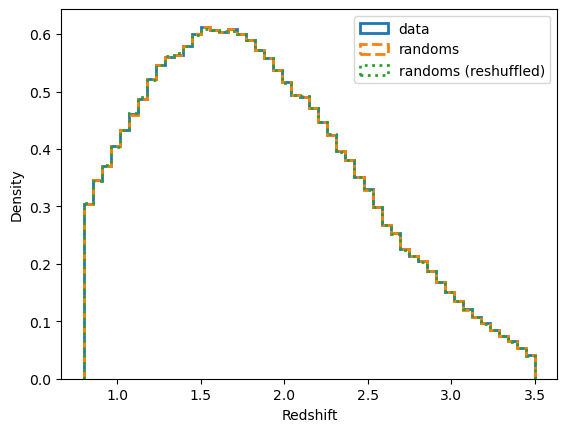

In [10]:
import matplotlib.pyplot as plt
hist_kws = dict(bins=50, histtype='step', density=True, lw=2)
plt.hist(data['Z'], weights=data['INDWEIGHT'], label='data', ls='-', **hist_kws)
plt.hist(randoms['Z'], weights=randoms['INDWEIGHT'], label='randoms', ls='--', **hist_kws)
plt.hist(randoms_reshuffled['Z'], weights=randoms_reshuffled['INDWEIGHT'], label='randoms (reshuffled)', ls=':', **hist_kws)
plt.xlabel('Redshift')
plt.ylabel('Density')
plt.legend()
plt.show()